In [10]:
import glob
import os
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, LeaveOneOut
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from scipy.ndimage import gaussian_filter1d
import argparse
data_dir = 'data_meg'
subj = "R2210"
dtype = "raw"
raw = mne.io.read_raw_fif('data_meg/R2210/prepro/R2210_raw_ica.fif', preload=True)
save_dir = 'data_meg'
bad_channels = ['MEG 079', 'MEG 076', 'MEG 068', 'MEG 015','MEG 014','MEG 147']

Opening raw data file data_meg/R2210/prepro/R2210_raw_ica.fif...


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_19957/415755201.py:22: RuntimeWarning: This filename (data_meg/R2210/prepro/R2210_raw_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif('data_meg/R2210/prepro/R2210_raw_ica.fif', preload=True)


    Range : 0 ... 2779999 =      0.000 ...  2779.999 secs
Ready.
Opening raw data file /Users/dorisyu/meg_decoding/data_meg/R2210/prepro/R2210_raw_ica-1.fif...
    Range : 2780000 ... 2954999 =   2780.000 ...  2954.999 secs
Ready.
Reading 0 ... 2954999  =      0.000 ...  2954.999 secs...


In [3]:

raw.info['bads'].extend(bad_channels)
# raw.drop_channels(bad_channels)
sfreq = raw.info['sfreq']
downsample =10 
raw = raw.resample(sfreq / downsample)
events = mne.find_events(raw, stim_channel='STI 014', output='onset', shortest_event=1)
event_id = {
    'start': 1,
    'move': 2,
    'reveal_red': 4,
    'reveal_white': 8,
    'done': 16,
}

5438 events found on stim channel STI 014
Event IDs: [ 1  2  4  8 16]
5438 events found on stim channel STI 014
Event IDs: [ 1  2  4  8 16]
5438 events found on stim channel STI 014
Event IDs: [ 1  2  4  8 16]


In [4]:
start_events = events[events[:, 2] == event_id['start']]
done_events = events[events[:, 2] == event_id['done']]
reveal_red_events = events[events[:, 2] == event_id['reveal_red']]
reveal_white_events = events[events[:, 2] == event_id['reveal_white']]
sfreq = raw.info['sfreq']  # Sampling frequency
# Initialize a list to store trial information
trial_info = []

done_idx = 0

# Iterate through each start event to create trial information
for idx, start_event in enumerate(start_events):
    start_sample = start_event[0]
    
    # Find the corresponding 'done' event
    while done_idx < len(done_events) and done_events[done_idx, 0] <= start_sample:
        done_idx += 1
    if done_idx < len(done_events):
        done_sample = done_events[done_idx, 0]
        
        # Calculate tmin and tmax for the epoch
        tmin = -0.2  # 0.2 s before 'start'
        tmax = (done_sample - start_sample) / sfreq + 1.0  # Duration from 'start' to 1 s after 'done'

        # Find reveal_red and reveal_white events within the trial
        reveal_red_within_trial = reveal_red_events[(reveal_red_events[:, 0] > start_sample) & 
                                                    (reveal_red_events[:, 0] < done_sample)]
        reveal_white_within_trial = reveal_white_events[(reveal_white_events[:, 0] > start_sample) & 
                                                        (reveal_white_events[:, 0] < done_sample)]
        
        # Store trial information, including whether 'reveal_red' and 'reveal_white' occurred
        trial_info.append({
            'event_sample': start_sample,
            'trial_index': done_idx,
            'duration': tmax,
            'tmin': tmin,
            'tmax': tmax,
            'start_times': start_sample / sfreq,
            'reveal_red': len(reveal_red_within_trial) > 0,  # Boolean flag indicating if 'reveal_red' occurred
            'reveal_red_times': (reveal_red_within_trial[:, 0] - start_sample) / sfreq if len(reveal_red_within_trial) > 0 else [],
            'reveal_white': len(reveal_white_within_trial) > 0,  # Boolean flag indicating if 'reveal_white' occurred
            'reveal_white_times': (reveal_white_within_trial[:, 0] - start_sample) / sfreq if len(reveal_white_within_trial) > 0 else [],
            'reveal_times': sorted(
                ((reveal_red_within_trial[:, 0] - start_sample) / sfreq).tolist() +
                ((reveal_white_within_trial[:, 0] - start_sample) / sfreq).tolist()
            ) 
        })  
        done_idx += 1

max_tmax = 80


In [23]:

# Initialize lists to store epochs and labels
epoch_data_before = []
epoch_data_after = []
labels = []

# Iterate through each start event to create trial information
for idx, start_event in enumerate(start_events):
    start_sample = start_event[0] +10
    
    # Define tmin and tmax for 1 second before and after the start event
    tmin_before = -0.3 # 1 second before start
    tmax_before = 0.0  # up to the start
    tmin_after = 0.0    # from the start
    tmax_after = 0.3   # 1 second after start
    picks = mne.pick_types(raw.info, meg=True, exclude='bads')
    # Extract epochs for 1 second before the start event
    epochs_before = mne.Epochs(
        raw, [start_event], tmin=tmin_before, tmax=tmax_before, preload=True,
        picks=picks, reject_by_annotation=False, reject=None, verbose=False, baseline=(0, 0)
    )
    epoch_data_before.append(epochs_before.get_data())
    labels.append(-1)  # Label for before start

    # Extract epochs for 1 second after the start event
    epochs_after = mne.Epochs(
        raw, [start_event], tmin=tmin_after, tmax=tmax_after, preload=True,
        picks=picks, reject_by_annotation=False, reject=None, verbose=False, baseline=(0, 0)
    )
    epoch_data_after.append(epochs_after.get_data())
    labels.append(1)  # Label for after start

# Combine the data and labels
epoch_data_combined = np.concatenate((epoch_data_before, epoch_data_after), axis=0)
labels_combined = np.array(labels)



In [6]:
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [16]:
X = epoch_data_shuffled.reshape(epoch_data_shuffled.shape[0], -1)  # Flatten Channels x Time
y = labels_shuffled  # Labels indicating the group

# Create a pipeline with a standard scaler and logistic regression
clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=1000))

# Use Leave-One-Out cross-validation
cv = LeaveOneOut()

# Perform cross-validation
accuracy = cross_val_score(clf, X, y, cv=cv).mean()

print(f"Decoding accuracy: {accuracy:.2f}")

Decoding accuracy: 0.65


In [24]:
new_events = np.array([[info['event_sample'], 0, event_id['start']] for info in trial_info])
tmin = -0.2  
# Initialize lists to store individual epochs data and trial information
epochs_data_list = []
trial_info_valid = []

# Iterate over new_events and create epochs, skipping the unwanted trials
for idx, event in enumerate(new_events):
    start_sample = event[0]
    event_id_code = event[2]
    event_time = start_sample / sfreq
    total_duration = raw.times[-1]

    # Determine available duration based on the next event or end of recording
    if idx < len(new_events) - 1:
        end_sample = new_events[idx + 1][0]
    else:
        end_sample = raw.n_times  

    # Calculate the available duration
    available_duration = (end_sample - start_sample) / sfreq
    print(available_duration)

    # Adjust tmin and baseline for the last epoch
    if idx == len(new_events) - 1:
        if (start_sample + tmin * sfreq) < 0:
            tmin_adjusted = - event_time + 0.001  # Small buffer
            baseline = None  # Disable baseline correction
            print(f"Adjusting tmin for last epoch to {tmin_adjusted} seconds and disabling baseline correction.")
        else:
            tmin_adjusted = tmin
            baseline = (tmin_adjusted, 0)
        max_possible_tmax = available_duration + tmin_adjusted
        actual_tmax = min(max_tmax, max_possible_tmax)
        print(f"Adjusting tmax for last epoch to {actual_tmax} seconds.")
    else:
        tmin_adjusted = tmin
        baseline = (tmin_adjusted, 0)
        actual_tmax = min(max_tmax, available_duration - tmin)
        print(f"Tmax for {actual_tmax} seconds")

    # Calculate epoch duration
    epoch_duration = actual_tmax - tmin_adjusted
    min_epoch_duration = 1 / sfreq  # Minimum duration is one sample

    # Create the epoch
    epochs = mne.Epochs(
        raw, [event], event_id={f'event_{event_id_code}': event_id_code},
        tmin=tmin_adjusted, tmax=actual_tmax, baseline=baseline, preload=True,
        reject_by_annotation=False, reject=None, verbose=True
    )

    # Append valid epochs to the list
    if len(epochs) > 0:
        epochs_data_list.append(epochs.get_data()[:, :, ::downsample])
        trial_info_valid.append(trial_info[idx])
    else:
        print(f"Epoch {idx} was dropped.")
        print(f"Drop log for Epoch {idx}: {epochs.drop_log}")


29.82
Tmax for 30.02 seconds
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 30221 original time points ...
0 bad epochs dropped
39.18
Tmax for 39.38 seconds
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 39581 original time points ...
0 bad epochs dropped
20.37
Tmax for 20.57 seconds
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 20771 original time points ...
0 bad epochs dropped
56.72
Tmax for 56.92 seconds
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 57121 original time points ...
0 bad epochs dropped
22.83
Tmax for 23.029999

# Decoding

In [4]:

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from mne.decoding import SlidingEstimator, cross_val_multiscore 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib import pyplot as plt
label_encoder = LabelEncoder()
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_predict 
import seaborn as sns   


In [206]:
labels_df = pd.read_csv('data_meg/R2210/labels_df.csv')
# Step 1: Get the valid trial indices
valid_trial_indices = {info['trial_index'] for info in trial_info_valid}

# Step 2: Filter labels_df to only include valid trial indices
labels_df_filtered = labels_df[labels_df['trial_index'].isin(valid_trial_indices)]

# Create a mapping from trial_index to label using the filtered labels_df
label_dict = dict(zip(labels_df_filtered['trial_index'], labels_df_filtered['trial.rule']))

# Step 3: Extract labels for the valid trials in trial_info_valid
y_labels = []
for info in trial_info_valid:
    idx = info['trial_index']
    if idx in label_dict:
        y_labels.append(label_dict[idx])

# Convert labels to integers using label encoder
y = label_encoder.fit_transform(y_labels)

# Print the number of labels and valid trials after matching
n_labels = len(y_labels)
n_trials = len(trial_info_valid)
print(f"Number of labels after matching: {n_labels}")
print(f"Number of valid trials after matching: {n_trials}")



Number of labels after matching: 120
Number of valid trials after matching: 120


In [248]:

def extract_reveal(trial_info_valid, raw, label_dict, event_name='reveal_red', n_points_before=50, n_points_after=50, event_index=-5):
    y_labels = []
    X_reveal = []
    trial_indices = []
    for info in trial_info_valid:
        # Check if there are enough events in this trial
        if len(info[f'{event_name}_times']) >= 4:
            # Get the event time
            event_time = info[f'{event_name}_times'][event_index]
            event_sample = int(event_time * sfreq)

            # Calculate start and end samples for extraction
            start_sample_before = event_sample - n_points_before
            start_sample_after = event_sample
            end_sample_after = event_sample + n_points_after

            # Ensure the samples are within bounds
            if start_sample_before >= 0 and end_sample_after <= raw.n_times:
                # Extract data for this trial
                epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after)
                X_reveal.append(epoch_data)
                # Append the corresponding label
                trial_index = info['trial_index']
                if trial_index in label_dict:
                    y_labels.append(label_dict[trial_index])
                    trial_indices.append(trial_index)

    return np.array(X_reveal), np.array(y_labels), trial_indices    

def extract_start(trial_info, raw, label_dict, n_points_before=0, n_points_after=50):
    X_start = []
    y_labels = []
    trial_indices = []
    for info in trial_info:
        # Get the done sample from the trial information
        start_sample = info['event_sample'] + int((info['tmin'] + 0.2) * raw.info['sfreq'])

        # Calculate start and end samples for extraction
        start_sample_before = start_sample - n_points_before
        end_sample_after = start_sample + n_points_after

        # Ensure the samples are within bounds
        if start_sample_before >= 0 and end_sample_after <= raw.n_times:
            # Extract data for this trial
            epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after)
            X_start.append(epoch_data)
            trial_index = info['trial_index']
            if trial_index in label_dict:
                y_labels.append(label_dict[trial_index])
                trial_indices.append(trial_index)

    return  np.array(X_start), np.array(y_labels), trial_indices


def extract_done(trial_info, raw, label_dict, n_points_before=50, n_points_after=100):
    X_done = []
    y_labels = []
    trial_indices = []
    for info in trial_info:
        # Get the done sample from the trial information
        done_sample = info['event_sample'] + int((info['tmax'] - 1.0) * raw.info['sfreq'])

        # Calculate start and end samples for extraction
        start_sample_before = done_sample - n_points_before
        end_sample_after = done_sample + n_points_after

        # Ensure the samples are within bounds
        if start_sample_before >= 0 and end_sample_after <= raw.n_times:
            # Extract data for this trial
            epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after)
            X_done.append(epoch_data)
            trial_index = info['trial_index']
            if trial_index in label_dict:
                y_labels.append(label_dict[trial_index])
                trial_indices.append(trial_index)

    return  np.array(X_done), np.array(y_labels), trial_indices


In [249]:
epoch_start, y_labels_start, trial_indices_start = extract_start(trial_info_valid, raw, label_dict)
epoch_1, y_labels_1, trial_indices_1 = extract_reveal(trial_info_valid, raw, label_dict,event_index=0)
epoch_2, y_labels_2, trial_indices_2 = extract_reveal(trial_info_valid, raw, label_dict, event_index=1)
epoch_3, y_labels_3, trial_indices_3 = extract_reveal(trial_info_valid, raw, label_dict, event_index=-2)
epoch_4, y_labels_4, trial_indices_4 = extract_reveal(trial_info_valid, raw, label_dict, event_index=-1)
epoch_done, y_labels_done, trial_indices_done = extract_done(trial_info_valid, raw, label_dict)
# Find common trial indices across all epochs
common_trial_indices = set(trial_indices_1) & set(trial_indices_2) & set(trial_indices_3) & set(trial_indices_4) & set(trial_indices_done)

# Convert to a sorted list to maintain order
common_trial_indices = sorted(common_trial_indices)

# Function to filter epochs and labels based on common trial indices
def filter_by_trial_indices(epochs, labels, trial_indices, common_indices):
    mask = [i for i, idx in enumerate(trial_indices) if idx in common_indices]
    return epochs[mask], labels[mask]

# Filter each epoch and labels
epoch_start_filtered, y_labels_start_filtered = filter_by_trial_indices(epoch_start, y_labels_start, trial_indices_start, common_trial_indices)
epoch_1_filtered, y_labels_1_filtered = filter_by_trial_indices(epoch_1, y_labels_1, trial_indices_1, common_trial_indices)
epoch_2_filtered, y_labels_2_filtered = filter_by_trial_indices(epoch_2, y_labels_2, trial_indices_2, common_trial_indices)
epoch_3_filtered, y_labels_3_filtered = filter_by_trial_indices(epoch_3, y_labels_3, trial_indices_3, common_trial_indices)
epoch_4_filtered, y_labels_4_filtered = filter_by_trial_indices(epoch_4, y_labels_4, trial_indices_4, common_trial_indices)
epoch_done_filtered, y_labels_done_filtered = filter_by_trial_indices(epoch_done, y_labels_done, trial_indices_done, common_trial_indices)

X_combined = np.concatenate(( epoch_1_filtered, epoch_2_filtered,epoch_3_filtered, epoch_4_filtered, epoch_done_filtered), axis=2)
print(f"Combined data shape: {X_combined.shape}")

# Use the labels from the first filtered epoch (assuming they are the same for all)
y_combined = y_labels_done_filtered

# Check the shape of the labels
print(f"Labels shape: {y_combined.shape}")

Combined data shape: (76, 193, 550)
Labels shape: (76,)


In [243]:

def evaluate_model(y_true, y_pred, class_names):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate weighted F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1:.2f}")

    # Print classification report for more detailed metrics
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


In [250]:
n_time_points = X_combined.shape[2]
n_classes = len(np.unique(y_combined))
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

def train_time_decoder(X, y, cv):
        # Train the time decoder on the entire dataset
    x_len = len(X)
    x_first = X[:x_len//2]
    y_first = y[:x_len//2]
    x_later = X[-x_len//2:]
    y_later = y[-x_len//2:]
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')
    
    # Perform cross-validation for the first 50 trials
    scores_first = cross_val_multiscore(time_decoding, x_first, y_first, cv=cv, n_jobs=5)
    mean_scores_first = np.mean(scores_first, axis=0)
    
    # Perform cross-validation for the later 50 trials
    scores_later = cross_val_multiscore(time_decoding, x_later, y_later, cv=cv, n_jobs=5)
    mean_scores_later = np.mean(scores_later, axis=0)
    return mean_scores_first, mean_scores_later


# Function to perform time decoding and plot results for two sets of trials
def plot_time_decoding(mean_scores_first, mean_scores_later,title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot the first 50 trials
    axes[0].plot(np.arange(n_time_points), mean_scores_first, label='First 50 Trials Accuracy')
    
    axes[0].axvline(x=100, color='r', linestyle='--', label='Reveal 1')
    axes[0].axvline(x=200, color='g', linestyle='--', label='Reveal -1')
    # axes[0].axvline(x=300, color='b', linestyle='--', label='Reveal -2')
    # axes[0].axvline(x=400, color='y', linestyle='--', label='Reveal -1')
    axes[0].axvline(x=300, color='m', linestyle='--', label='Done')
    axes[0].axhline(1/n_classes, color='k', linestyle='--', label='chance')
    axes[0].set_xlabel('Time Points')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('First 50 Trials')
    axes[0].legend(loc='upper right')
    axes[0].set_ylim(0, 0.7)

    # Plot the later 50 trials
    axes[1].plot(np.arange(n_time_points), mean_scores_later, label='Later 50 Trials Accuracy', linestyle='--')
    axes[1].axvline(x=100, color='r', linestyle='--', label='Reveal 1')
    axes[1].axvline(x=200, color='g', linestyle='--', label='Reveal -1')
    # axes[1].axvline(x=480, color='b', linestyle='--', label='Reveal -2')
    # axes[1].axvline(x=640, color='y', linestyle='--', label='Reveal -1')
    axes[1].axvline(x=300, color='m', linestyle='--', label='Done')
    axes[1].axhline(1/n_classes, color='k', linestyle='--', label='chance')
    axes[1].set_xlabel('Time Points')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Later 50 Trials')
    axes[1].legend(loc='upper right')
    axes[1].set_ylim(0, 0.7)


    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



In [251]:
from scipy.ndimage import gaussian_filter1d
mean_scores_first, mean_scores_later = train_time_decoder(X_combined, y_combined, cv)
# Function to smooth the scores using a Gaussian filter
def smooth_scores(scores, sigma=2):
    return gaussian_filter1d(scores, sigma=sigma)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




  0%|          | Fitting SlidingEstimator : 0/550 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 1/550 [00:00<01:33,    5.85it/s][A
  0%|          | Fitting SlidingEstimator : 2/550 [00:00<00:52,   10.50it/s]


  1%|          | Fitting SlidingEstimator : 5/550 [00:00<00:22,   24.58it/s]

  0%|          | Fitting SlidingEstimator : 1/550 [00:00<01:57,    4.69it/s]
  1%|          | Fitting SlidingEstimator : 5/550 [00:00<00:24,   22.33it/s]


  1%|          | Fitting SlidingEstimator : 5/550 [00:00<00:25,   21.65it/s]

  1%|          | Fitting SlidingEstimator : 3/550 [00:00<00:44,   12.22it/s]

  1%|          | Fitting SlidingEstimator : 5/550 [00:00<00:30,   17.97it/s]


  1%|▏         | Fitting SlidingEstimator : 7/550 [00:00<00:25,   21.27it/s]
  1%|          | Fitting SlidingEstimator : 6/550 [00:00<00:30,   17.74it/s]


  1%|▏         | Fitting SlidingEstimator : 7/550 [00:00<00:27, 

(0.0, 0.7)

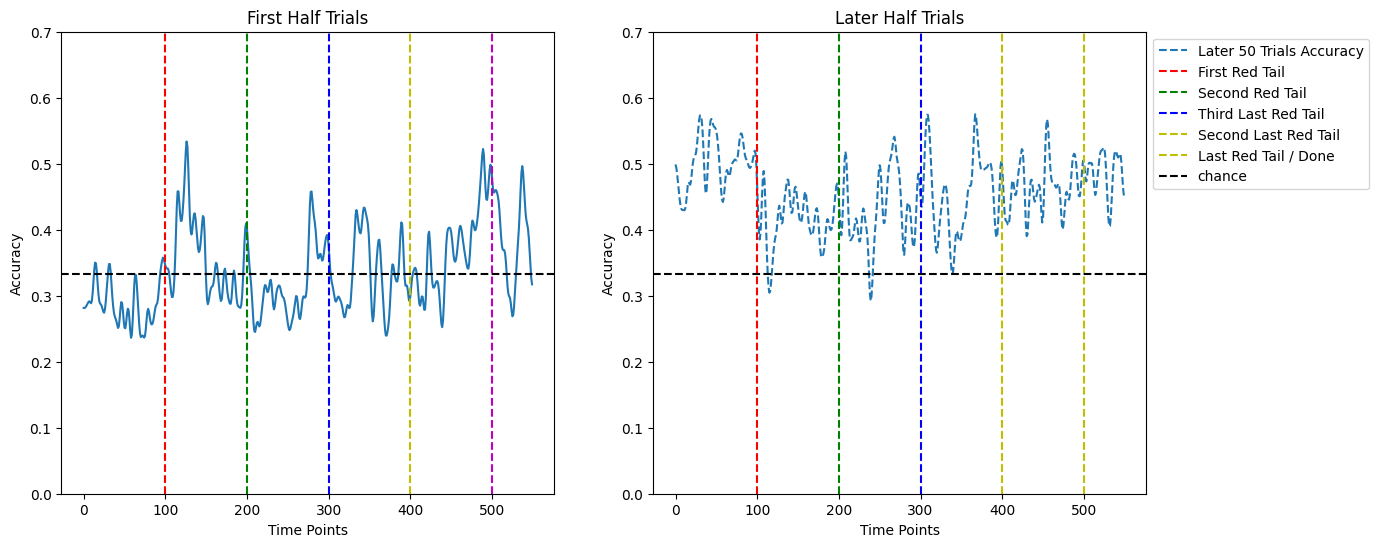

In [254]:

# Plot the first 50 trials
smoothed_scores_first = smooth_scores(mean_scores_first)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(np.arange(n_time_points), smoothed_scores_first, label='First 50 Trials Accuracy')
# axes[0].axvline(x=100, color='b', linestyle='--', label='Start')
axes[0].axvline(x=100, color='r', linestyle='--', label='Reveal 1')
axes[0].axvline(x=200, color='g', linestyle='--', label='Reveal -1')
axes[0].axvline(x=300, color='b', linestyle='--', label='Reveal -2')
axes[0].axvline(x=400, color='y', linestyle='--', label='Reveal -1')
axes[0].axvline(x=500, color='m', linestyle='--', label='Done')
axes[0].axhline(1/n_classes, color='k', linestyle='--', label='chance')
axes[0].set_xlabel('Time Points')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('First Half Trials')
axes[0].set_ylim(0, 0.7)

# Plot the later 50 trials
smoothed_scores_later = smooth_scores(mean_scores_later)
axes[1].plot(np.arange(n_time_points), smoothed_scores_later, label='Later 50 Trials Accuracy', linestyle='--')
# axes[1].axvline(x=50, color='b', linestyle='--', label='Start')
axes[1].axvline(x=100, color='r', linestyle='--', label='First Red Tail')
axes[1].axvline(x=200, color='g', linestyle='--', label='Second Red Tail')
axes[1].axvline(x=300, color='b', linestyle='--', label='Third Last Red Tail')
axes[1].axvline(x=400, color='y', linestyle='--', label='Second Last Red Tail')
axes[1].axvline(x=500, color='y', linestyle='--', label='Last Red Tail / Done')
axes[1].axhline(1/n_classes, color='k', linestyle='--', label='chance')
axes[1].set_xlabel('Time Points')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Later Half Trials')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].set_ylim(0, 0.7)



In [ ]:
# Plot the comparison
plot_time_decoding(mean_scores_first, mean_scores_later, 'Time Decoding Accuracy Comparison')
